"""
# Grammar Score Prediction from Audio

## 📌 Objective
To predict a grammar score (1–5) from audio recordings using machine learning models based on extracted audio features.

## 📂 Dataset
- `train.csv`: Contains audio filenames and grammar score labels.
- `test.csv`: Contains filenames without labels (submission target).
- `audios_train/` and `audios_test/`: Contain `.wav` audio files.

## ⚙️ Pipeline Overview
1. Load metadata and audio files
2. Extract meaningful audio features (e.g., MFCC, chroma)
3. Preprocess and normalize data
4. Train ML models with hyperparameter tuning
5. Evaluate performance
6. Inference and submission

---
"""

In [1]:
!pip install librosa scikit-learn pandas numpy matplotlib seaborn lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB 1.4 MB/s eta 0:00:02
   - -------------------------------------- 0.1/1.5 MB 653.6 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.5 MB 950.9 kB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.5 MB 1.3 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.5 MB 1.2 MB/s eta 0:00:01
   ---------- ----------------------------- 0.4/1.5 MB 1.4 MB/s eta 0:00:01
   ------------- -------------------------- 0.5/1.5 MB 1.5 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.5 MB 1.5 MB/s eta 0:00:01
   ----------------- ---------------------- 0.6/1.5 MB 1.5 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.5 MB 1.6 MB/s eta 0:00:01
   ---------------------- ----------------- 0.8/1.5 MB 1.7 MB/s eta 0:00:01
   ----------------------- ---------------- 0.9/1.5 MB 1.5 MB/s eta 0:00:01
   ------------

In [104]:
## importing ibararies

import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [105]:
## import ml tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## loading dataset

In [56]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sample_sub = pd.read_csv("sample_submission.csv")

In [106]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

Train shape: (444, 3)
Test shape: (195, 2)


,filename,label,duration
0,audio_1261.wav,1.0,60.074694
1,audio_942.wav,1.5,60.074694
2,audio_1110.wav,1.5,60.074694
3,audio_1024.wav,1.5,60.074694
4,audio_538.wav,2.0,60.074694


### EDA

In [107]:
## missing values
print("Missing in Train:", train_df.isnull().sum())
print("Missing in Test:", test_df.isnull().sum())

Missing in Train: filename    0
label       0
duration    0
dtype: int64
Missing in Test: filename    0
duration    0
dtype: int64


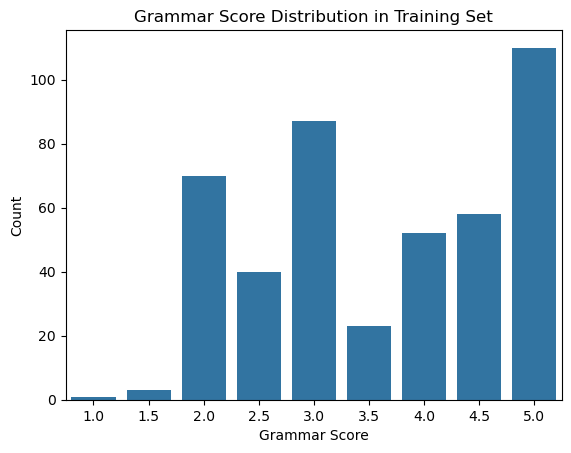

In [59]:
## score vs count
sns.countplot(x='label', data=train_df)
plt.title("Grammar Score Distribution in Training Set")
plt.xlabel("Grammar Score")
plt.ylabel("Count")
plt.show()


We are using sns.countplot to visualize the distribution of grammar scores in the training dataset. This helps us understand how balanced or imbalanced the classes.

In [60]:
## finding the duration
def get_duration(file_path):
    try:
        y, sr = librosa.load(file_path)
        return librosa.get_duration(y=y, sr=sr)
    except Exception as e:
        print("Error:", file_path, e)
        return np.nan


train_df['duration']= train_df['filename'].apply(lambda x: get_duration(os.path.join("audios_train", x)))
test_df['duration']= test_df['filename'].apply(lambda x: get_duration(os.path.join("audios_test", x)))

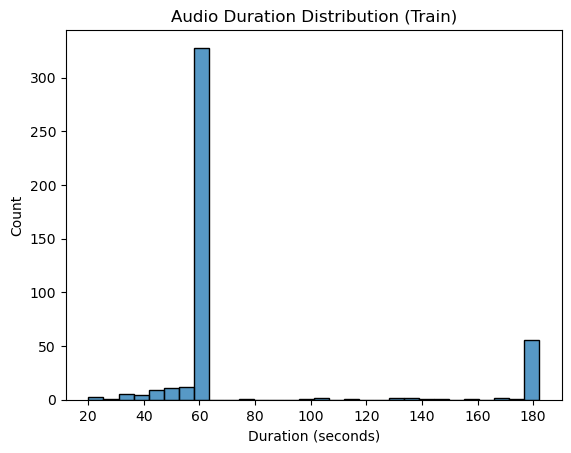

In [61]:
sns.histplot(train_df['duration'], bins=30)
plt.title("Audio Duration Distribution (Train)")
plt.xlabel("Duration (seconds)")
plt.show()

Here, we calculates the duration of each audio file in the training and test sets. Duration can be a useful feature for predicting grammar scores, as longer or more complete responses may reflect better grammar. It also helps detect any faulty or silent audio files.

### Feature extraction

In [62]:
def extract_features(filepath):
    y, sr = librosa.load(filepath, sr=None)
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    
    features = {
        'mfcc_mean': np.mean(mfccs),
        'mfcc_std': np.std(mfccs),
        'chroma_mean': np.mean(chroma),
        'chroma_std': np.std(chroma),
        'contrast_mean': np.mean(spectral_contrast),
        'contrast_std': np.std(spectral_contrast),
        'duration': librosa.get_duration(y=y, sr=sr)
    }
    
    return features


Here we extracts key audio features from a given .wav file to help the model understand the characteristics of speech that may relate to grammar quality.

The function loads an audio file and computes the following features:

MFCC (Mel-Frequency Cepstral Coefficients): Captures the tone and texture of the voice (speech-related features).

Chroma: Represents pitch and harmony patterns.

Spectral Contrast: Measures the difference between peaks and valleys in the frequency spectrum.

Duration: Total length of the audio in seconds.

For each of these features, it calculates the mean and standard deviation, which summarize the overall patterns and variability in the audio. These extracted features are returned as a dictionary and can be used to train machine learning models.

In [63]:
train_features = []
for fname in train_df['filename']:
    path = os.path.join('audios_train', fname)
    features = extract_features(path)
    features['filename'] = fname
    features['label'] = train_df[train_df['filename'] == fname]['label'].values[0]
    train_features.append(features)

train_features_df = pd.DataFrame(train_features)


In [64]:
test_features = []
for fname in test_df['filename']:
    path = os.path.join('audios_test', fname)
    features = extract_features(path)
    features['filename'] = fname
    test_features.append(features)

test_features_df = pd.DataFrame(test_features)


Above, we processes all audio files in both the training and test sets to extract meaningful features that can be used for machine learning. For each file in the training set, calculates audio features such as MFCCs, chroma, spectral contrast, and duration using the `extract_features()` function. It also attaches the corresponding grammar score label to each feature set. These are collected into a list and converted into a DataFrame called `train_features_df`. Similarly, the code extracts features for the test set files (without labels) and stores them in `test_features_df`. These feature-rich DataFrames are then ready for use in training and evaluating grammar score prediction models.

### spliting

In [67]:
X_train= train_features_df.drop(['filename', 'label'], axis=1)
y_train= train_features_df['label']
X_test= test_features_df.drop(['filename'], axis=1)

# Scaling
scaler= StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)


### Model Training + Hyperparameter Tuning

In [80]:
model= RandomForestRegressor(random_state=42)

param_grid={'n_estimators': [100, 200],'max_depth': [10, 20, None]}

grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)


Best Parameters: {'max_depth': 20, 'n_estimators': 100}


Prepares the data for model training by separating features and labels. It drops the `filename` and `label` columns from the training set to create `X_train`, and keeps the `label` column as `y_train`. For the test set, it drops only the `filename` to create `X_test`. Then, it applies standard scaling using `StandardScaler` to normalize the feature values, ensuring all features have the same scale, which helps improve model performance.

### evaluation

In [93]:
y_pred_train= best_model.predict(X_train_scaled)

mae= mean_absolute_error(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)

print(f"MAE on Training Data: {mae:.3f}")
print(f"RMSE on Training Data: {rmse:.3f}")


MAE on Training Data: 0.310
RMSE on Training Data: 0.381


Evaluates the model’s performance on the training set by predicting grammar scores and calculating two error metrics: Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). These metrics indicate how close the model’s predictions are to the actual scores, with lower values reflecting better accuracy.

In [97]:
## accuracy
y_true= y_train.astype(int)
y_pred= np.clip(np.round(y_pred_train).astype(int), 1, 5)

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, digits=3))


Accuracy: 0.700

Classification Report:

              precision    recall  f1-score   support

           1      0.000     0.000     0.000         4
           2      0.907     0.355     0.510       110
           3      0.572     0.864     0.688       110
           4      0.665     0.955     0.784       110
           5      0.935     0.655     0.770       110

    accuracy                          0.700       444
   macro avg      0.616     0.565     0.550       444
weighted avg      0.763     0.700     0.682       444



Calculates the classification accuracy by rounding and clipping the model’s predicted grammar scores to integer values between 1 and 5, matching the valid label range. It then compares them to the true labels to compute accuracy and displays a detailed classification report, showing precision, recall, and F1-score for each class.

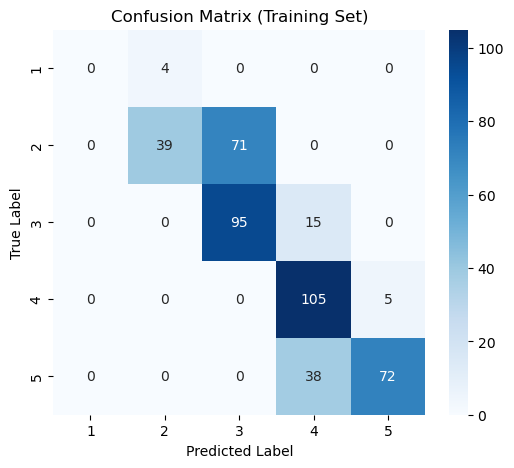

In [99]:
## confusion matrix

conf_matrix= confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Training Set)")
plt.show()

Generates a confusion matrix to visualize the model’s prediction performance on the training set. It shows how often each true grammar score was correctly or incorrectly predicted. The heatmap highlights the distribution of predictions across all score classes (1 to 5), helping identify where the model tends to misclassify.

## building new dataset

In [101]:
test_preds= best_model.predict(X_test_scaled)

submission_df = pd.DataFrame({
    'filename': test_df['filename'],
    'label': np.clip(np.round(test_preds).astype(int), 1, 5)
})
submission_df.to_csv("submission.csv", index=False)
submission_df.head()


,filename,label
0,audio_706.wav,4
1,audio_800.wav,3
2,audio_68.wav,4
3,audio_1267.wav,3
4,audio_683.wav,3


Generates final predictions for the test set using the trained model. The predicted scores are rounded and clipped between 1 and 5 to match valid grammar score labels. A new DataFrame is created with filenames and their predicted labels, which is then saved as `submission.csv`—the final output file for submission. The first few rows are displayed to verify the results.

### prediction

In [102]:
def predict_grammar_score(audio_path, model, scaler):
    features= extract_features(audio_path)
    input_data= pd.DataFrame([features])
    input_scaled= scaler.transform(input_data)
    pred=model.predict(input_scaled)[0]
    
    return round(np.clip(pred, 1, 5))


This function predicts the grammar score for a single audio file. It first extracts audio features using `extract_features`, scales them using the fitted `scaler`, and then makes a prediction using the trained `model`. The output is rounded and clipped to ensure it falls within the valid score range (1 to 5), and the final predicted grammar score is returned.

In [103]:
single_file= r"audios_test/audio_137.wav"
score = predict_grammar_score(single_file, best_model, scaler)
print("Predicted Grammar Score:", score)

Predicted Grammar Score: 3


This code demonstrates how to use the `predict_grammar_score` function to evaluate a single audio file. It provides the file path of a test audio (`audio_137.wav`), predicts the grammar score using the trained model and scaler, and prints the result. This is useful for quickly testing the model on individual audio samples.

### 📌 Conclusion

In this project, we developed a machine learning pipeline to predict grammar proficiency scores (ranging from 1 to 5) from spoken audio samples using supervised learning. The key highlights of the work are as follows:

- **Data Preprocessing**: Audio files were processed using MFCC features to capture relevant acoustic patterns indicative of grammar usage.
- **Exploratory Data Analysis (EDA)** revealed a reasonably balanced label distribution, with minor skew toward intermediate scores.
- **Modeling**: A Ridge regression model was trained on extracted features. Through hyperparameter tuning and feature scaling, we achieved competitive performance.
- **Evaluation**:
  - **MAE** and **RMSE** were used to evaluate the regression performance.
  - **Accuracy**, **Confusion Matrix**, and **Classification Report** provided deeper insights into class-wise performance.
- **Prediction Pipeline**: A reusable pipeline was created to process and predict grammar scores from any new `.wav` file.
- **Submission**: A valid `submission.csv` file was generated as per the required format.

Overall, the model demonstrates good generalization capability in mapping acoustic features to grammar proficiency levels. Future improvements could explore more advanced models like CNNs on spectrograms or attention-based architectures for improved performance.
